In [27]:
import pathlib as plb
import tarfile
import urllib.request
import polars as pl
import matplotlib.pyplot as plt
import numpy as np
%xmode Plain
%matplotlib Inline
plt.style.use('dark_background')

Exception reporting mode: Plain


shape: (9, 11)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬──────────┐
│ statistic ┆ longitude ┆ latitude  ┆ housing_m ┆ … ┆ household ┆ median_in ┆ median_ho ┆ ocean_pr │
│ ---       ┆ ---       ┆ ---       ┆ edian_age ┆   ┆ s         ┆ come      ┆ use_value ┆ oximity  │
│ str       ┆ f64       ┆ f64       ┆ ---       ┆   ┆ ---       ┆ ---       ┆ ---       ┆ ---      │
│           ┆           ┆           ┆ f64       ┆   ┆ f64       ┆ f64       ┆ f64       ┆ str      │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪══════════╡
│ count     ┆ 20640.0   ┆ 20640.0   ┆ 20640.0   ┆ … ┆ 20640.0   ┆ 20640.0   ┆ 20640.0   ┆ 20640    │
│ null_coun ┆ 0.0       ┆ 0.0       ┆ 0.0       ┆ … ┆ 0.0       ┆ 0.0       ┆ 0.0       ┆ 0        │
│ t         ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ mean      ┆ -119.5697 ┆ 35.631861 ┆ 28.639486 ┆ … ┆ 499.53968 ┆ 3.870671  

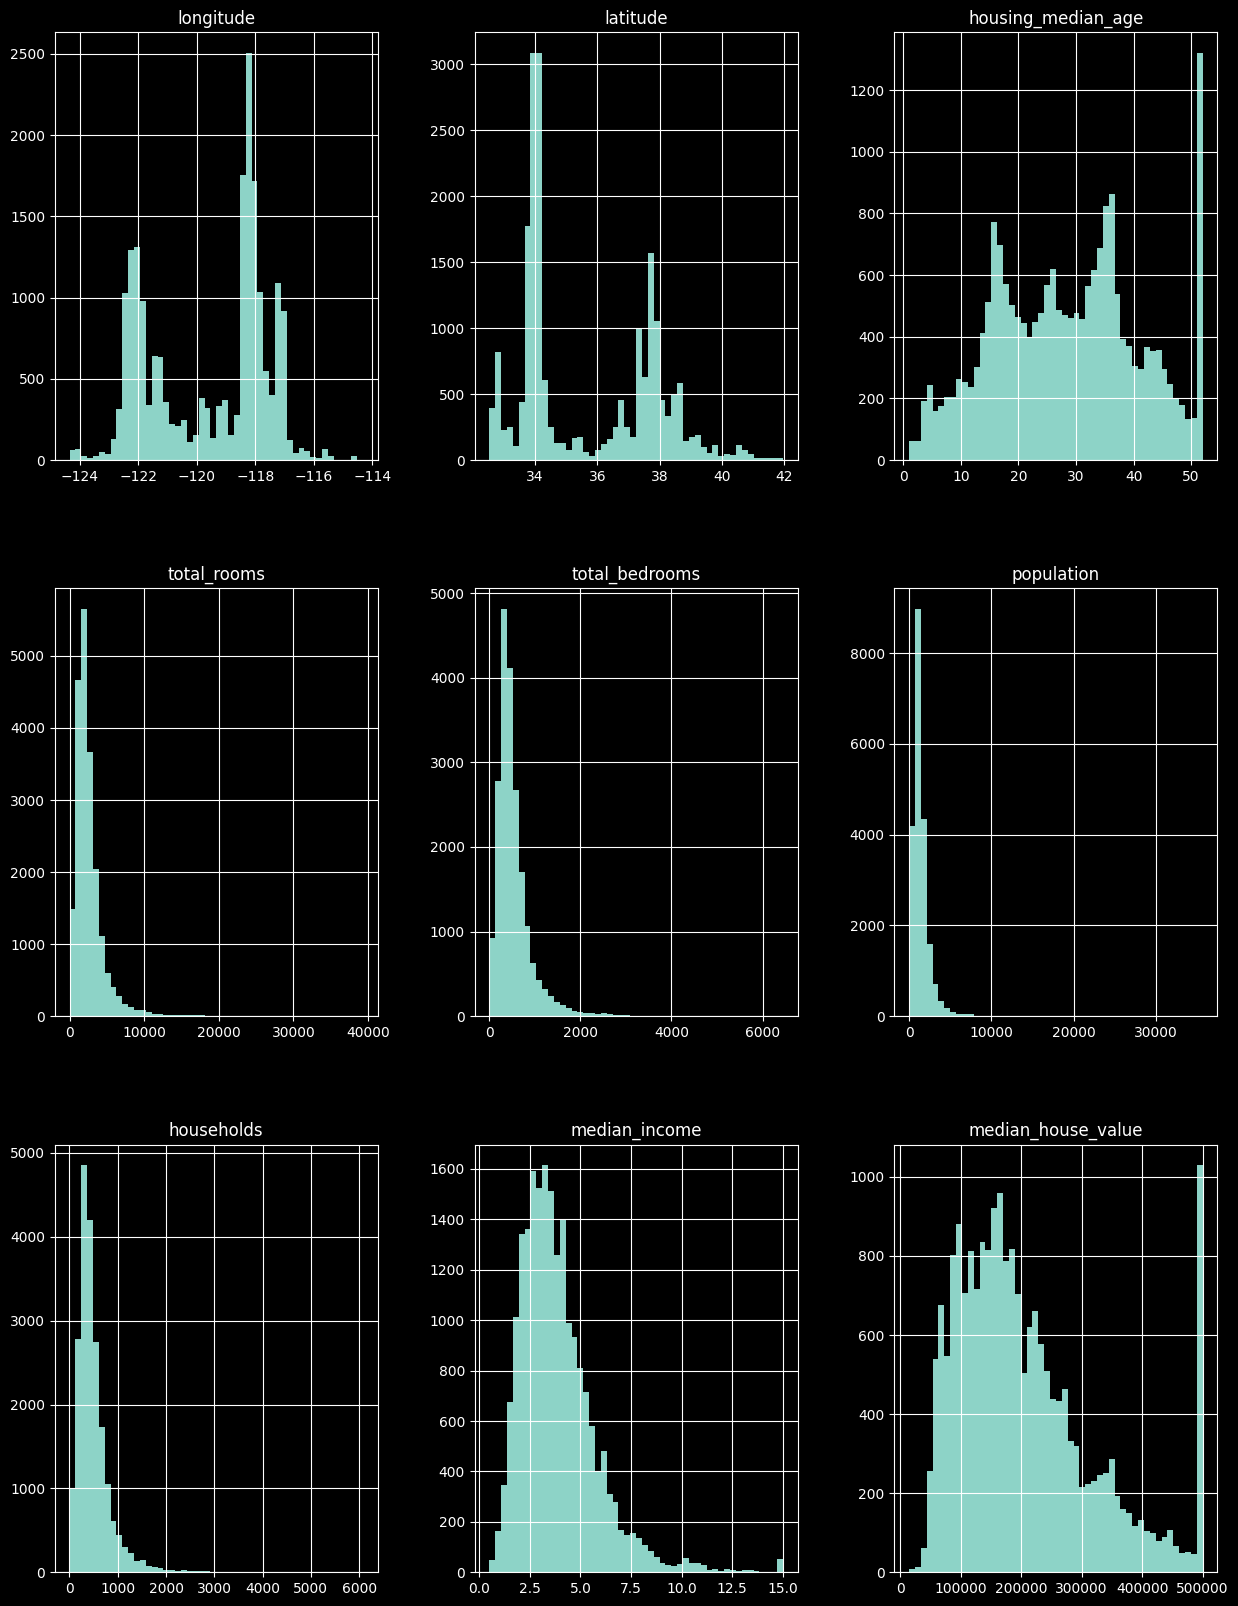

In [28]:
#downloading data and first insights
download_path = "https://raw.githubusercontent.com/ageron/handson-ml2/master/datasets/housing/housing.tgz"
file_path = plb.Path("datasets","housing","housing.tgz")

file_path.parent.mkdir(parents=True,exist_ok = True)
urllib.request.urlretrieve(download_path, file_path)
with tarfile.open(file_path) as f:
	f.extractall(path=file_path.parent)

new_path = plb.Path(file_path.parent,"housing.csv")

housing_data = pl.read_csv(new_path)
print(housing_data.describe())

housing_data.to_pandas().hist(bins = 50, figsize = (15,20))
plt.show()

In [29]:
#spliting data into train set and test set
from sklearn.model_selection import StratifiedShuffleSplit, train_test_split

#preparing data for method 3
housing_data = housing_data.with_columns(
    (
        pl.col('median_income') \
        .cut(breaks = [1.5,3,4.5,6], labels = ['1','2','3','4','5']) \
        .alias('median_income_cat')
    )
)
#check
#plt.hist(housing_data_cat.select(pl.col('median_income_cat')))

#method1 - fully random
def split_train_test(data, test_ratio):
 shuffled_indices = np.random.permutation(len(data))
 test_set_size = int(len(data) * test_ratio)
 test_indices = shuffled_indices[:test_set_size]
 train_indices = shuffled_indices[test_set_size:]
 return data[train_indices], data[test_indices]
train_set1, test_set1 = split_train_test(housing_data, 0.2)

#method 2 - normal sklearn
train_set2, test_set2 = train_test_split(housing_data,test_size = 0.2, random_state = 42)
train_set2, test_set2

#method 3 - stratified
splitbase = StratifiedShuffleSplit(n_splits = 1, test_size = 0.2, random_state = 42)
for train_index, test_index in splitbase.split(housing_data, housing_data['median_income_cat']):
    strat_train_set = housing_data[train_index]
    strat_test_set = housing_data[test_index]

# final checks
#creating a summarizing DataFrame
checkdf = pl.DataFrame(
            strat_test_set['median_income_cat'].value_counts().rename({'count':'count_strat'}) \
                .join(test_set1['median_income_cat'].value_counts(), on ='median_income_cat').rename({'count':'count_random'}) \
                .join(test_set2['median_income_cat'].value_counts(), on ='median_income_cat').rename({'count':'count_overall'}) \
                .sort(pl.col('median_income_cat'))
                .cast({'median_income_cat':pl.String})
).cast({"count_strat":pl.Int64,
    "count_random":pl.Int64,
    "count_overall":pl.Int64})
#Creating a Df for checking if all sums are the same
sums = pl.DataFrame({
    'median_income_cat':'Sum', 
    'count_strat':checkdf['count_strat'].sum(), 
    'count_random':checkdf['count_random'].sum(), 
    'count_overall':checkdf['count_overall'].sum()
})
#final Df and conclusion
checkdf = pl.concat([checkdf,sums])
print(checkdf)
print('Strat and overall are the best, random is significantly skewed')
housing = strat_train_set.select(pl.exclude('median_income_cat')).clone()
pd_housing = housing.to_pandas()

shape: (6, 4)
┌───────────────────┬─────────────┬──────────────┬───────────────┐
│ median_income_cat ┆ count_strat ┆ count_random ┆ count_overall │
│ ---               ┆ ---         ┆ ---          ┆ ---           │
│ str               ┆ i64         ┆ i64          ┆ i64           │
╞═══════════════════╪═════════════╪══════════════╪═══════════════╡
│ 1                 ┆ 165         ┆ 169          ┆ 166           │
│ 2                 ┆ 1316        ┆ 1324         ┆ 1339          │
│ 3                 ┆ 1447        ┆ 1446         ┆ 1480          │
│ 4                 ┆ 728         ┆ 703          ┆ 691           │
│ 5                 ┆ 472         ┆ 486          ┆ 452           │
│ Sum               ┆ 4128        ┆ 4128         ┆ 4128          │
└───────────────────┴─────────────┴──────────────┴───────────────┘
Strat and overall are the best, random is significantly skewed


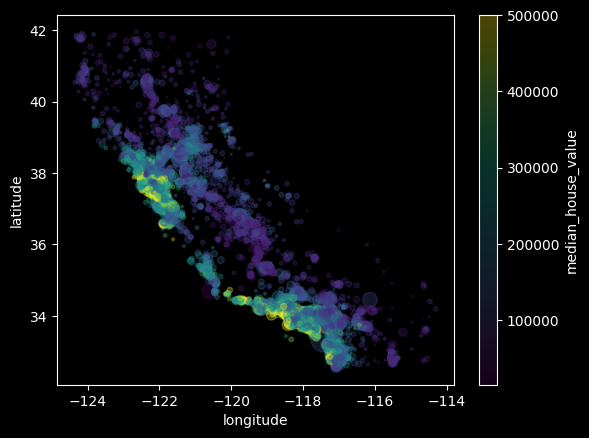

median_house_value    1.000000
median_income         0.687151
total_rooms           0.135140
housing_median_age    0.114146
households            0.064590
total_bedrooms        0.047781
population           -0.026882
longitude            -0.047466
latitude             -0.142673
Name: median_house_value, dtype: float64


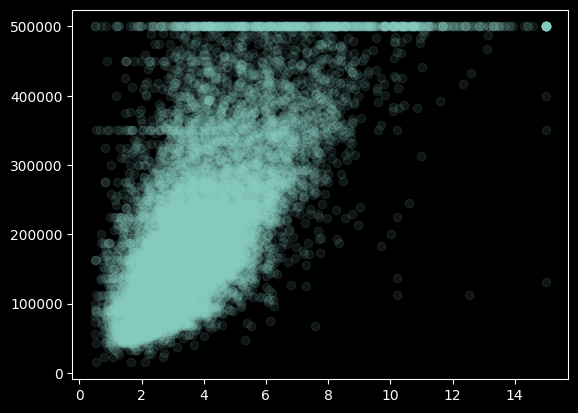

In [30]:
#Gaining more insights
#Visualising house value by location and population density
plt.scatter(x = housing['longitude'], y = housing['latitude'], alpha = 0.3, s = housing['population']/100, label = 'population',
            c = housing['median_house_value'])
plt.xlabel('longitude')
plt.ylabel('latitude')
plt.colorbar(label = 'median_house_value')
plt.show()

#Creating a correlation martix and visualising correlations
corr_matrix = housing.select(pl.exclude('ocean_proximity','median_income_cat')).to_pandas().corr()
print(corr_matrix['median_house_value'].sort_values(ascending = False))

from pandas.plotting import scatter_matrix 
attributes = ["median_house_value", "median_income", "total_rooms", "housing_median_age"]
# scatter_matrix(pd_housing[attributes], figsize=(12, 8))
plt.scatter(x = housing['median_income'], y = housing['median_house_value'], alpha = 0.1)

In [32]:
#Preparing data for a model
housing = strat_train_set.select(pl.exclude('median_house_value','median_income_cat'))
housing_labels = strat_train_set.get_column('median_house_value')

#filling null values by inserting a median
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy = 'median')
housing_num = housing.select(pl.exclude('ocean_proximity'))
imputer.fit(housing_num)

# checks
# imputer.statistics_
# housing_num.median()
X = imputer.transform(housing_num)
housing_tr = pl.DataFrame(X, schema = housing_num.columns)
# check
# housing_tr.null_count()

# handling text data
from sklearn.preprocessing import OneHotEncoder
housing_text = strat_train_set.select(pl.col('ocean_proximity'))
text_encoder = OneHotEncoder()
housing_text_encoded = text_encoder.fit_transform(housing_text).toarray()

#Adding an attribute
from sklearn.base import BaseEstimator, TransformerMixin

rooms_ix, bedrooms_ix, population_ix, households_ix = 3, 4, 5, 6


class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True): # no *args or **kargs
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self # nothing else to do
    def transform(self, X, y=None):
        rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
        population_per_household = X[:, population_ix] / X[:, households_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household,
            bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing)


In [33]:
#doing it all by a pipeline
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
num_pipeline = Pipeline([
 ('imputer', SimpleImputer(strategy="median")),
 ('attribs_adder', CombinedAttributesAdder()),
 ('std_scaler', StandardScaler()),
 ])


from sklearn.compose import ColumnTransformer
num_attribs = list(housing_num.columns)
cat_attribs = ["ocean_proximity"]
full_pipeline = ColumnTransformer([
 ("num", num_pipeline, num_attribs),
 ("cat", OneHotEncoder(), cat_attribs),
 ])
housing_prepared = full_pipeline.fit_transform(housing)

In [34]:
#Actually a Model (Linear one, not ideal)
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(housing_prepared,housing_labels)

some_data = housing[:5]
some_labels = housing_labels[:5]
some_data_prepared = full_pipeline.transform(some_data)
print('Predictions:',lin_reg.predict(some_data_prepared))

from sklearn.metrics import mean_squared_error
housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
print('RMSE:', lin_rmse)

Predictions: [ 85657.90192014 305492.60737488 152056.46122456 186095.70946094
 244550.67966089]
RMSE: 68627.87390018745


In [35]:
## Different models - Decision Tree, and random forest, comparing to Regression
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
tree_reg = DecisionTreeRegressor()
tree_reg.fit(housing_prepared, housing_labels)
print(0)
forest_reg = RandomForestRegressor()
forest_reg.fit(housing_prepared, housing_labels)

tree_scores = cross_val_score(tree_reg, housing_prepared, housing_labels, scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-tree_scores)

lin_scores = cross_val_score(lin_reg, housing_prepared, housing_labels,scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)

forest_scores = cross_val_score(forest_reg, housing_prepared, housing_labels, scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)

def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())
display_scores(tree_rmse_scores)
display_scores(lin_rmse_scores)
display_scores(forest_rmse_scores)

0
Scores: [71258.90611032 70226.46076233 68164.5001164  72741.15518873
 69698.26707133 79632.14547016 71047.23932731 73650.69161558
 67943.39543653 70997.69338461]
Mean: 71536.04544833009
Standard deviation: 3185.016601040087
Scores: [71762.76364394 64114.99166359 67771.17124356 68635.19072082
 66846.14089488 72528.03725385 73997.08050233 68802.33629334
 66443.28836884 70139.79923956]
Mean: 69104.07998247063
Standard deviation: 2880.3282098180634
Scores: [51341.89643197 48974.87574739 46720.99752239 51739.63223707
 47323.72985992 51984.56746215 52330.0051538  50020.33964613
 48899.19767159 54144.83506393]
Mean: 50348.00767963431
Standard deviation: 2243.665325998098


In [47]:
#Fine tuning by grid and randomized search
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

param_grid = [
 {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
 {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
 ]
forest_reg = RandomForestRegressor()
grid_search = GridSearchCV(forest_reg, param_grid, cv=5, scoring='neg_mean_squared_error', return_train_score=True)
grid_search.fit(housing_prepared, housing_labels)
print(grid_search.best_estimator_)
random_search = RandomizedSearchCV(forest_reg, param_grid, scoring = 'neg_mean_squared_error', cv = 5, return_train_score = True)
random_search.fit(housing_prepared, housing_labels)
print(random_search.best_estimator_)

RandomForestRegressor(max_features=6, n_estimators=30)
RandomForestRegressor(max_features=6, n_estimators=30)


In [46]:
#Displaying feature importances
feature_importances = grid_search.best_estimator_.feature_importances_
extra_attribs = ["rooms_per_hhold", "pop_per_hhold", "bedrooms_per_room"]
cat_encoder = full_pipeline.named_transformers_["cat"]
cat_one_hot_attribs = list(cat_encoder.categories_[0])
attributes = num_attribs + extra_attribs + cat_one_hot_attribs
sorted(zip(feature_importances, attributes), reverse=True)

[(np.float64(0.3347051791036195), 'median_income'),
 (np.float64(0.17114256163864985), 'INLAND'),
 (np.float64(0.10971852334275704), 'pop_per_hhold'),
 (np.float64(0.07974445331514965), 'bedrooms_per_room'),
 (np.float64(0.07534087239846847), 'longitude'),
 (np.float64(0.06689566466918206), 'latitude'),
 (np.float64(0.04925802477214146), 'rooms_per_hhold'),
 (np.float64(0.04010295726838853), 'housing_median_age'),
 (np.float64(0.015556367851801626), 'total_rooms'),
 (np.float64(0.015179543516343858), 'population'),
 (np.float64(0.014566627110707664), 'total_bedrooms'),
 (np.float64(0.013502798826197709), 'households'),
 (np.float64(0.007778059455612557), '<1H OCEAN'),
 (np.float64(0.004473792703626485), 'NEAR OCEAN'),
 (np.float64(0.0019599073754571674), 'NEAR BAY'),
 (np.float64(7.466665189642518e-05), 'ISLAND')]

In [56]:
# Evaluating on a test set
final_model = grid_search.best_estimator_

X_test = strat_test_set.select(pl.exclude('median_house_value'))
Y_test = strat_test_set.get_column('median_house_value').clone()

X_test_prepared = full_pipeline.transform(X_test)

final_predictions = final_model.predict(X_test_prepared)

final_mse = mean_squared_error(Y_test, final_predictions)
final_rmse = np.sqrt(final_mse)
final_rmse

from scipy import stats
confidence = 0.95
squared_errors = (final_predictions - Y_test)**2
np.sqrt(stats.t.interval(confidence, len(squared_errors) - 1,
                        loc = squared_errors.mean(),
                        scale = stats.sem(squared_errors())))

TypeError: 'Series' object is not callable